In [214]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Funnynet

## A neural network that makes jokes

Special thanks to taivop for providing the [dataset](https://github.com/taivop/joke-dataset).

This notebook is heavily inspired by [fastai NLP work](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb).

In [215]:
import pdb
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

In [216]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

PATH=Path('data')

In [217]:
files = list(PATH.iterdir())
print(files)

[WindowsPath('data/reddit_jokes.json'), WindowsPath('data/stupidstuff.json')]


In [218]:
reddit_dataset = files[0]
reddit_jokes = json.load(open(reddit_dataset))
stupid_dataset = files[1]
stupid_jokes = json.load(open(stupid_dataset))

In [219]:
len(reddit_jokes)

194553

In [220]:
len(stupid_jokes)

3773

In [221]:
reddit_jokes[0]

{'body': 'Now I have to say "Leroy can you please paint the fence?"',
 'id': '5tz52q',
 'score': 1,
 'title': 'I hate how you cant even say black paint anymore'}

Let's discard all the jokes that have 0 score, as they aren't that helpful for training

In [222]:
rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

In [223]:
len(rated_jokes)

132992

In [224]:
scores = [joke['score'] for joke in rated_jokes]
np.mean(scores),np.max(scores)

(172.94791416025024, 48526)

In [225]:
stupid_scores = [joke['rating'] for joke in stupid_jokes]
np.mean(stupid_scores),np.max(stupid_scores)

(3.284362576199311, 5.0)

Let's see how many jokes have really high scores:

In [226]:
len([score for score in scores if score>5000])

1067

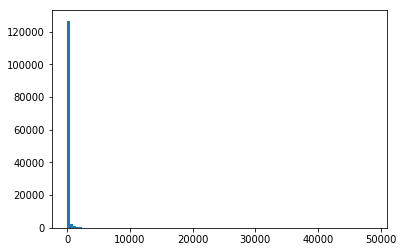

In [ ]:
plt.hist(scores, bins=100);

Looks like there's quite a dropoff of scores, almost none above 1000. Score normalization or something might be useful -- a large amount of the score is probably due to posting time, so it might be valuable to batch all the score into "unpopular", "semi-popular", and "very popular" or something.

In [ ]:
low_scores = [score for score in scores if score<5000]
plt.hist(low_scores, bins=100);

Here are the Reddit joke score incidences plotted on a log scale on the y axis:

In [ ]:
low_scores = [score for score in scores]
plt.yscale('log', nonposy='clip')
plt.hist(low_scores, bins=100);

Here are the Reddit joke score incidences plotted on a log scale on the x axis:

In [ ]:
low_scores = [score for score in scores]
plt.xscale('log', nonposx='clip')
plt.ylim(ymax=200000)
#plt.axes.set_ylim([0,200000])
plt.hist(low_scores, bins=100);

This suggests that we can take the log of the Reddit scores (and multiply by an appropriate factor to ensure we cover the whole 0 to 5 range) and then easily combine the Reddit corpus with the stupidstuff corpus (see the flattish distribution of the stupidstuff jokes below).

Now let's look at the score distribution for the jokes from the stupidstuff corpus

In [ ]:
stupid_scores_for_hist = [score for score in stupid_scores if score<=5]
plt.hist(stupid_scores_for_hist,bins=50);

Let's try combining the datasets:

In [ ]:
logged_reddit = [math.log(score)/math.log(10)*5/3 for score in scores if math.log10(score)*5/3 <= 5] #[math.log(score)/math.log(10) for score in scores]
plt.hist(logged_reddit, bins=100);

In [ ]:
combined = [score for score in logged_reddit]
combined = combined + [score for score in stupid_scores_for_hist]
plt.hist(combined,bins=5);

While there are still more jokes below average than above average (about 8 times as many jokes in the 0.0 to 1.0 range as in the 4.0 to 5.0 range), this is much more evenly distributed, perhaps even acceptably much so for our purposes.

Next up, let's combine all the jokes in title->body format.

In [ ]:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]
title_body[0]

Horrible, but formatted correctly. Now, let's combine all the jokes into one long string. This will destroy any ability for the network to understand what the baginning or end of a joke is, but I'll come back to that. 

In [ ]:
text = ''
for joke in title_body:
    text = text + ' ' + joke + ' ' + EOJ + ' '
    if len(text) > 700000: 
        break

In [ ]:
len(text)

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

In [ ]:
chars.insert(0, "\0")
print(chars)

It appears there are Emojis in the dataset. 

In [ ]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

In [ ]:
idx = [char_indices[c] for c in text]

idx[:10]

In [ ]:
''.join(indices_char[i] for i in idx[:70])